In [1]:
import sys
import numpy as np
np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from itertools import zip_longest
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
import random
import pandas as pd
from numba import jit, njit

In [2]:
SEED = 8
random.seed(SEED)
def shuffle_forward(l):
    order = list(range(len(l)))
    random.shuffle(order)
    return np.array(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

# Optimized Functions with Numba

In [22]:
@njit
def nb_LIF(I, dT, V_rest, V_thresh, V_spike, Rm, Cm):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = I.size * dT

        # an array of time
        time = np.arange(0, total_time, dT)

        # default voltage list set to resting volatage of -65mV
        V = V_rest * np.ones(len(time))

        did_spike = False

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - V_rest) / Rm) / Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = V_rest + dV * dT
            else:
                V[t] = V[t - 1] + dV * dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = V_spike
            else:
                did_spike = False

        return V

@njit
def nb_voltage_to_output(V_input, V_spike):
    """Converts a neuron's internal voltage to output"""
    V_output = np.zeros(V_input.shape)
    for i, v in enumerate(V_input):
        V_output[i] = 0 if v < V_spike else V_spike
    return V_output

@njit
def nb_voltage_to_spike_rate(voltages, V_spike, dT, rate):
    """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
#         print('voltages', voltages)
    
    spike_count = 0
    for v in voltages:
        if v >= V_spike:
            spike_count += 1

    #         print('spike_count', spike_count)

    total_time_dT = len(voltages) * dT
    #         print(f'total_time_dT: {total_time_dT} ({dT}ms)')

    spikes_per_dT = spike_count / total_time_dT
    #         print(f'spikes_per_ms: {spikes_per_dT} (spikes/ms)')

    return spikes_per_dT * 1000 * rate

@njit
def nb_new_weight(weight, a_corr, input_rate, output_rate, w_max, w_decay):
    # adjust the weight using Hebb with decay
    weight_change = a_corr * input_rate * output_rate - w_decay
#                         print('\told weight', weight)
#                         print('\tweight_change:', weight_change)
    new_weight = 0
    if weight + weight_change < 0:
        new_weight = 0
    elif weight + weight_change > w_max:
        new_weight = w_max
    else:
        new_weight = weight + weight_change
    return new_weight

In [23]:
class SingleLayerSNN:
    def __init__(
        self,
        inputs,
        weights,
        trainings,
        Cm=4.0,
        Rm=5.0,
        V_thresh=30.0,
        V_rest=-65.0,
        V_spike=80.0,
        dT=0.01,
        rate=1.0,
    ):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """

        assert len(trainings) == len(inputs)

        self.inputs = inputs
        self.weights = weights
        self.trainings = trainings
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT  # ms
        self.rate = rate  # sec
        self._LIF_spikes = 0
    
    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        return nb_LIF(I, self.dT, self.V_rest, self.V_thresh, self.V_spike, self.Rm, self.Cm)
    
    def voltage_to_output(self, V_input):
        """Converts a neuron's internal voltage to output"""
        return nb_voltage_to_output(V_input, self.V_spike)

    def voltage_to_spike_rate(self, voltages, dT=None, rate=None):
        """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
        if not dT:
            dT = self.dT
        if not rate:
            rate = self.rate
            
        return nb_voltage_to_spike_rate(voltages, self.V_spike, dT, rate)

    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, train=True):
        """
        Passes all sets of inputs to 

                Parameters:
                        inputs (double[][][]): A 3d numpy array that contains every set of inputs voltages for each input neuron
                        train (boolean): Determines whether or not to inject training voltages

                Returns:
                        all_input_voltages, all_output_voltages (double[][][], double[][][]): A tuple of all of the input voltages and all of the output voltages
        """
        all_input_voltages = np.zeros(inputs.shape)
        all_output_voltages = np.zeros(self.trainings.shape)

        # set the training voltages to all zero if not running in training mode
        training_copy = (
            np.zeros(inputs.shape, np.ndarray)
            if not train
            else np.array(self.trainings)
        )
        #         print('training_copy:')
        #         print(training_copy)

        inputs_copy = np.array(inputs)
        #         print('inputs_copy:')
        #         print(inputs_copy)

        assert len(training_copy) == len(inputs_copy)

        zipped = list(zip(inputs_copy, training_copy))

        shuffled, order = shuffle_forward(zipped)
        shuffled_inputs, shuffled_trainings = zip(*shuffled)

        shuffled_inputs = np.array(shuffled_inputs)
        #         print('shuffled_inputs:')
        #         print(shuffled_inputs)

        shuffled_trainings = np.array(shuffled_trainings)
        #         print('shuffled_trainings:')
        #         print(shuffled_trainings)
        
        # feed inputs through input neurons to get weighted voltage for output neurons
        for i, (input_set, training_set) in enumerate(zip_longest(shuffled_inputs, shuffled_trainings)):
            
            for j, V_input in enumerate(input_set):
                temp = np.array(V_input)
                all_input_voltages[i][j] = self.LIF(temp.astype(float))
            input_voltages = all_input_voltages[i]
            
            output_inputs = np.zeros(self.trainings[0].shape)
#             input_outputs = []  # DEBUG ONLY
            for j, weight_set in enumerate(self.weights.T):
                weighted_sum = np.zeros(len(input_set[0]))
                for V_input, weight in zip(input_voltages, weight_set):
                    # filter for spikes b/c a neuron only outputs if it spikes
                    input_output = self.voltage_to_output(V_input)
#                     input_outputs.append(input_output)  # DEBUG ONLY
                    weighted = input_output * weight
                    weighted_sum = np.add(weighted_sum, weighted)

                output_inputs[j] = weighted_sum

#             input_outputs = np.array(input_outputs)

            #             print('input_voltages:')
            #             print(input_voltages)
            #             print('input_outputs:')
            #             print(input_outputs)
            #             print('output_inputs:')
            #             print(output_inputs)
            #             print('training_set:')
            #             print(training_set)

            # inject training voltage if in training mode
            assert isinstance(training_set, (list, np.ndarray))
            for j, (output_input, training_input) in enumerate(
                zip(output_inputs, training_set)
            ):
                assert isinstance(training_input, (list, np.ndarray))
#               padded_training_input = np.pad(training_input, (0, len(output_inputs) - len(training_set)), "constant")
                output_inputs[j] = output_input + training_input

#             print('output_inputs after injecting training current')
#             print(output_inputs)

            # run LIF on output neurons
            for j, V_input in enumerate(output_inputs):
                all_output_voltages[i][j] = self.LIF(V_input)

            output_voltages = all_output_voltages[i]

#             print('output_voltages:')
#             print(output_voltages)

        # unshuffle the voltages
        all_input_voltages = np.array(shuffle_backward(all_input_voltages, order))
        all_output_voltages = np.array(shuffle_backward(all_output_voltages, order))

        return all_input_voltages, all_output_voltages

    def train(self, epochs=75, a_corr=0.000000002, w_max=2, w_decay=0, show_legend=True):
        """Runs feed forward with training dataset"""
        weights_history = []
        for weight_set in self.weights:
            weight_row = []
            for weight in weight_set:
                weight_row.append([weight])
            weights_history.append(weight_row)

        for epoch in range(epochs):
            print(f"Epoch: {epoch + 1}")
            
            print('\trunning feed forward...')
            all_input_voltages, all_output_voltages = self.feed_forward(
                self.inputs, train=True
            )

            # debug info
            #             print()
            #             print('------------------------------------------------')
            #             print('all_input_voltages:')
            #             print(all_input_voltages)
            #             print('all_output_voltages:')
            #             print(all_output_voltages)

            #             print('weights:')
            #             print(self.weights)
            
            print('\tapplying learning rule...')
            # apply learning rule
            for input_voltages, output_voltages in zip(
                all_input_voltages, all_output_voltages
            ):
#                 print('input_voltages:')
#                 print(input_voltages)
                for i, (input_voltage_set, weight_set) in enumerate(
                    zip(input_voltages, self.weights)
                ):
#                     print('input_voltage_set', input_voltage_set)
                    input_rate = self.voltage_to_spike_rate(input_voltage_set)
#                     print(f'input_rate {i}:', input_rate)

                    for j, (output_voltage_set, weight) in enumerate(
                        zip(output_voltages, weight_set)
                    ):
                        output_rate = self.voltage_to_spike_rate(output_voltage_set)
#                         print(f'\toutput_rate {j}:', output_rate)

                        # adjust the weight using Hebb with decay
                        self.weights[i][j] = nb_new_weight(self.weights[i][j], a_corr, input_rate, output_rate, w_max, w_decay)

#                         print('\tnew weight', self.weights[i][j], '\n')

            # update weight history
            for i, weight_set in enumerate(self.weights):
                for j, weight in enumerate(weight_set):
                    weights_history[i][j].append(weight)
            
            print('\tweights:')
            print('\t' + str(self.weights).replace('\n','\n\t'))

        # plot neuron spiking data
        #             for i, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
        #                 plt.figure(figsize=(20,10))
        #                 plt.title(f'Input: {i + 1}')
        #                 for input_voltage in input_voltages:
        #                     plt.plot(input_voltage, 'b:', alpha=.5)

        #                 for output_voltage in output_voltages:
        #                     plt.plot(output_voltage, 'r--', alpha=.5)

        #             plt.show()

        # plot weights history
        plt.figure(figsize=(20, 10))
        for i, weight_row in enumerate(weights_history):
            for j, weight_history in enumerate(weight_row):
                plt.plot(weight_history, label=f"weight {i}-{j}")
                plt.xlabel('Epoch')
        if show_legend:
            plt.legend(loc="upper left")
        plt.title("Weight History")
        plt.show()
        
    def _generate_bar_plot(self, outputs, title='', ylabel='', stacked=False):
        d = {}
        """Generates bar plot for output neuron data"""
        for x, bars in enumerate(outputs.T):
            d[f'Output Neuron {x}'] = bars
        index = [f'{x}' for x in range(len(outputs.T[0]))]
        df = pd.DataFrame(d, index=index)
        ax = df.plot.bar(rot=0, figsize=(20, 10), stacked=stacked, title=title)
        ax.set_xlabel('Input Set')
        ax.set_ylabel(ylabel)

    def predict(self, inputs, bar_width=0.25):
        """Runs feed foward without training data on inputs"""
        all_input_voltages, all_output_voltages = self.feed_forward(inputs, train=False)
#         print('all_output_voltages')
#         print(all_output_voltages)

        all_output_confidences = []
        all_output_spike_rates = []

        for x, (input_voltages, output_voltages) in enumerate(
            zip(all_input_voltages, all_output_voltages)
        ):
            output_spike_rates = []
            output_confidences = []
            print("input set:", x)
            for i, input_voltage_set in enumerate(input_voltages):
                print(
                    f"\tinput {i}: {self.voltage_to_spike_rate(input_voltage_set)} spikes/{self.rate}s"
                )
            print()

            output_voltages_sum = sum(
                [self.voltage_to_spike_rate(v) for v in output_voltages]
            )
            for i, output_voltage_set in enumerate(output_voltages):
                sr = self.voltage_to_spike_rate(output_voltage_set)
                output_spike_rates.append(sr)
                confidence = (
                    "N/A" if output_voltages_sum == 0 else sr / output_voltages_sum
                )
                output_confidences.append(0 if confidence == "N/A" else confidence)
                print(
                    f"\toutput {i}: {sr} spikes/{self.rate}s, confidence: {confidence}"
                )
            print()
            all_output_spike_rates.append(output_spike_rates)
            all_output_confidences.append(output_confidences)

        all_output_confidences = np.array(all_output_confidences)
        all_output_spike_rates = np.array(all_output_spike_rates)

        #         print(all_output_confidences)
        #         print(all_output_spike_rates)

        # plot output confidence
        self._generate_bar_plot(all_output_confidences, title="Output Confidence", ylabel="Confidence", stacked=True,)
        # plot output spike rates
        self._generate_bar_plot(
            all_output_spike_rates,
            ylabel=f"Spike Rate (spikes/{self.rate}s)",
            title="Output Spike Rates",

        )
        return all_input_voltages, all_output_voltages


# Logical AND

Epoch: 1
	running feed forward...
	applying learning rule...
	weights:
	[[0.038415 0.012705]
	 [0.       0.02581 ]
	 [0.038415 0.012805]
	 [0.       0.02571 ]]
Epoch: 2
	running feed forward...
	applying learning rule...
	weights:
	[[0.07683 0.02511]
	 [0.      0.05122]
	 [0.07683 0.02521]
	 [0.      0.05112]]
Epoch: 3
	running feed forward...
	applying learning rule...
	weights:
	[[0.115245 0.037515]
	 [0.       0.07663 ]
	 [0.115245 0.037615]
	 [0.       0.07653 ]]
Epoch: 4
	running feed forward...
	applying learning rule...
	weights:
	[[0.15366 0.04992]
	 [0.      0.10204]
	 [0.15366 0.05002]
	 [0.      0.10194]]
Epoch: 5
	running feed forward...
	applying learning rule...
	weights:
	[[0.192075 0.062325]
	 [0.       0.12745 ]
	 [0.192075 0.062425]
	 [0.       0.12735 ]]
Epoch: 6
	running feed forward...
	applying learning rule...
	weights:
	[[0.23049 0.07473]
	 [0.      0.15286]
	 [0.23049 0.07483]
	 [0.      0.15276]]
Epoch: 7
	running feed forward...
	applying learning rule...
	we

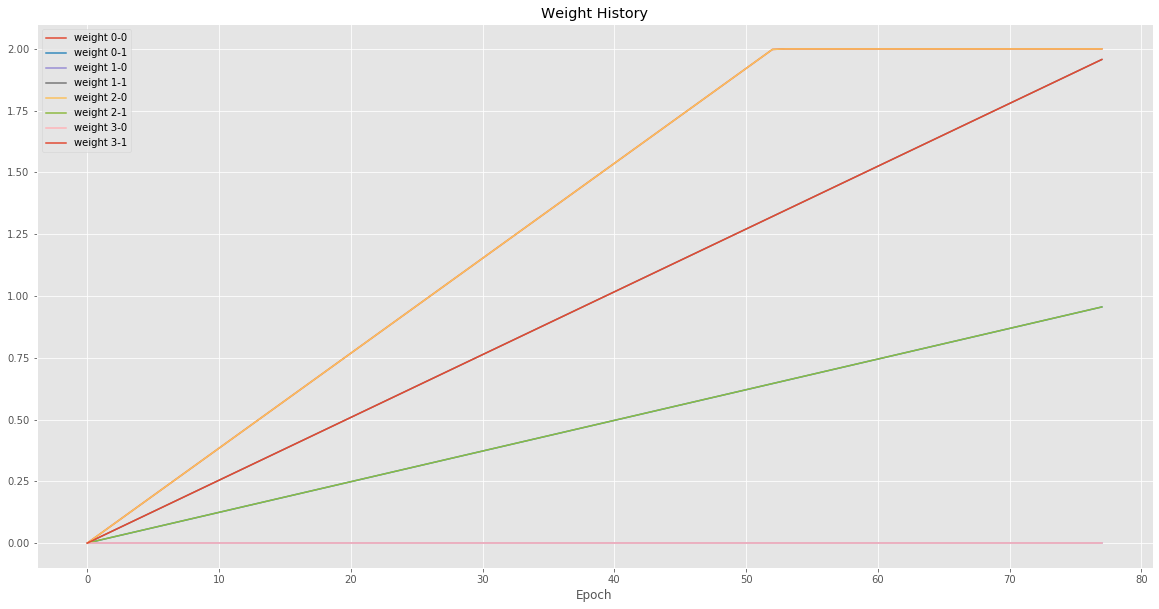

input set: 0
	input 0: 25000.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 25000.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s

	output 0: 150.0 spikes/1.0s, confidence: 0.75
	output 1: 50.0 spikes/1.0s, confidence: 0.25

input set: 1
	input 0: 25000.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 25000.0 spikes/1.0s

	output 0: 50.0 spikes/1.0s, confidence: 0.3333333333333333
	output 1: 100.0 spikes/1.0s, confidence: 0.6666666666666666

input set: 2
	input 0: 0.0 spikes/1.0s
	input 1: 25000.0 spikes/1.0s
	input 2: 25000.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s

	output 0: 50.0 spikes/1.0s, confidence: 0.3333333333333333
	output 1: 100.0 spikes/1.0s, confidence: 0.6666666666666666

input set: 3
	input 0: 0.0 spikes/1.0s
	input 1: 25000.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 25000.0 spikes/1.0s

	output 0: 0.0 spikes/1.0s, confidence: 0.0
	output 1: 150.0 spikes/1.0s, confidence: 1.0



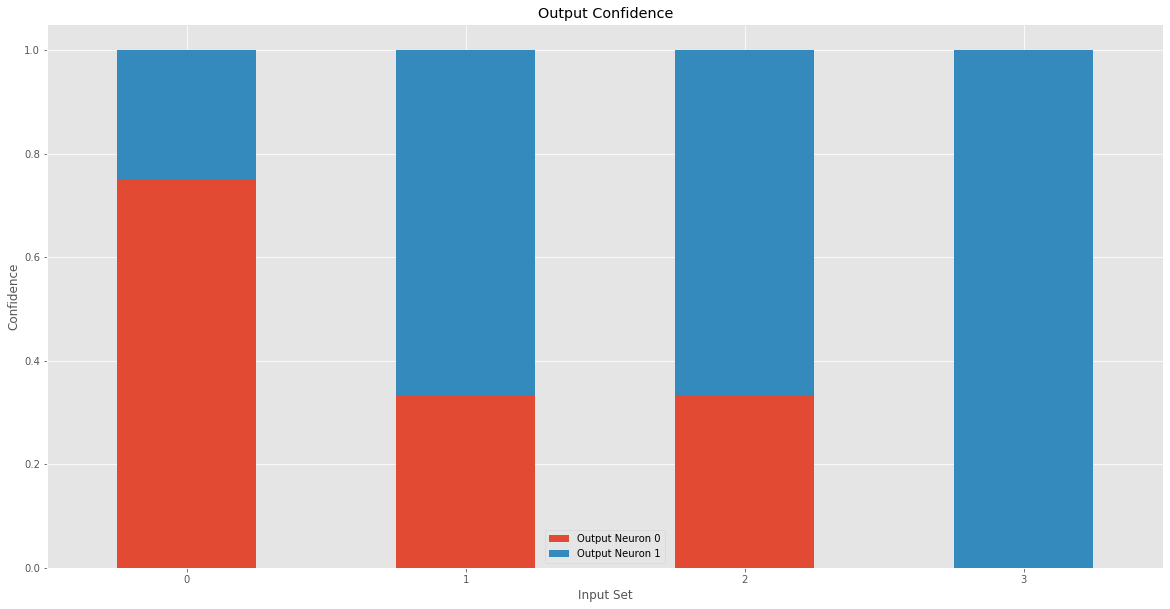

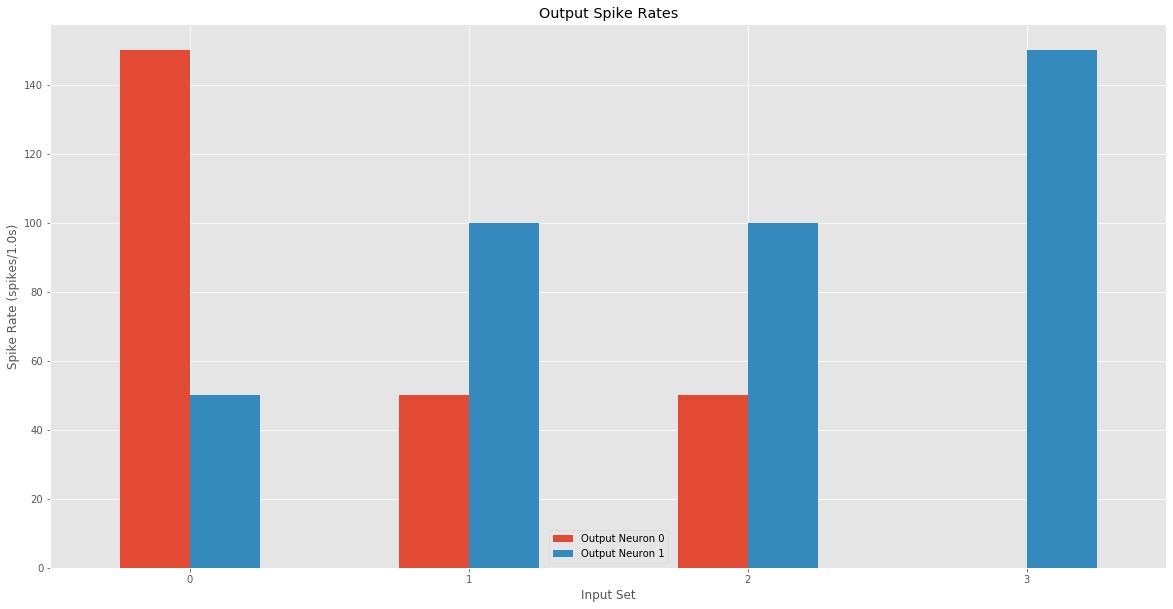

In [24]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

and_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR AND NETWORK: epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001
and_network.train(epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001)

p_a = 10000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)

and_network.predict(predict_inputs);


# Logical OR

In [ ]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F

    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

or_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR OR NETWORK: epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001
# or_network.train(epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001)

p_a = 100000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
# or_network.predict(predict_inputs);


# Digit Classification

Epoch: 1
	running feed forward...
	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00102525 0.         0.
	  0.         0.         0.         0.        ]
	 [0.00453875 0.00021875 0.00264575 0.0335225  0.         0.02687575
	  0.         0.0027385  0.01164625 0.0154565 ]
	 [0.034676   0.00719825 0.00765475 0.0457625  0.00551125 0.0194935
	  0.02608325 0.02434725 0.01837825 0.02768375]
	 [0.03027725 0.04116375 0.0190405  0.04128725 0.02343525 0.01553375
	  0.0316295  0.03742875 0.02034175 0.01236375]
	 [0.00144225 0.0220005  0.01819225 0.01660875 0.00029375 0.0127925
	  0.00205    0.03069675 0.0077375  0.00079375]
	 [0.         0.         0.         0.00045025 0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.001063   0.         0.
	  0.         0.         0.         0.        ]
	 [0.013662   0.000225   0.002729   0.101248   0.         0.0803405
	  0.         0.0048835  0.03361475 0.04501275]
	 [0.104904   0.0145065  0.02273525 0.138275   0.0142895  0.058049
	  0.078025   0.0723015  0.053935   0.08190125]
	 [0.0916215  0.1249135  0.0572495  0.12471125 0.0699555  0.0440725
	  0.09484275 0.1118025  0.059738   0.03360925]
	 [0.00317525 0.0668705  0.05237025 0.04862925 0.000325   0.035795
	  0.0021     0.0914745  0.020382   0.000825  ]
	 [0.         0.         0.         0.000463   0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.0011385  0.         0.
	  0.         0.         0.         0.        ]
	 [0.02322575 0.0002375  0.002729   0.1704275  0.         0.1345185
	  0.         0.0072435  0.05612475 0.07508875]
	 [0.17659075 0.0224375  0.03832925 0.23262475 0.0234095  0.097173
	  0.1313845  0.1209155  0.090173   0.13691125]
	 [0.154252   0.21096275 0.0960615  0.2098345  0.1173215  0.0730825
	  0.159745   0.1870925  0.09998    0.05533925]
	 [0.00525875 0.11312825 0.08707425 0.08155125 0.000325   0.059215
	  0.0022     0.1530365  0.033532   0.000825  ]
	 [0.         0.         0.         0.0004885  0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00115125 0.         0.
	  0.         0.         0.         0.        ]
	 [0.03376275 0.0002375  0.002729   0.24204075 0.         0.18990925
	  0.         0.01028325 0.07863475 0.105557  ]
	 [0.25119875 0.03090825 0.05402975 0.33017475 0.03262325 0.13723625
	  0.18660875 0.17169575 0.126411   0.1924    ]
	 [0.219545   0.299281   0.1355155  0.2979075  0.16487075 0.1029425
	  0.22671425 0.2652815  0.140222   0.07729925]
	 [0.00804675 0.1608655  0.12244675 0.1159045  0.000325   0.083387
	  0.0022     0.21698075 0.046682   0.00085625]
	 [0.         0.         0.         0.00050125 0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00117625 0.         0.
	  0.         0.         0.         0.        ]
	 [0.0446275  0.00024375 0.0028955  0.3148615  0.         0.24694025
	  0.         0.0135795  0.1022885  0.13744425]
	 [0.3269325  0.03989325 0.070679   0.42921225 0.04268425 0.17863425
	  0.24292125 0.2231865  0.164286   0.25008125]
	 [0.28585175 0.3894185  0.1765395  0.38733    0.21433175 0.1338375
	  0.29498025 0.3445365  0.1820065  0.1003845 ]
	 [0.01112875 0.2096705  0.15925475 0.15098925 0.0003875  0.108477
	  0.00225    0.28190125 0.06057175 0.0008875 ]
	 [0.         0.         0.         0.00050125 0.         0.
	  0.         0.00001275 0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00125175 0.         0.
	  0.         0.         0.         0.        ]
	 [0.055768   0.00025625 0.0028955  0.3892855  0.         0.30445875
	  0.         0.01712625 0.1264335  0.169573  ]
	 [0.4036255  0.04972825 0.087692   0.53023725 0.05292425 0.220405
	  0.30057175 0.27555825 0.202687   0.30814275]
	 [0.35301575 0.4826005  0.21785125 0.4785685  0.26428875 0.1650825
	  0.36479275 0.424991   0.2245655  0.12378975]
	 [0.01440125 0.260551   0.1962885  0.18703325 0.0003875  0.133868
	  0.00235    0.34781425 0.07499675 0.0008875 ]
	 [0.         0.         0.         0.00052675 0.         0.
	  0.         0.000063   0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.0012645  0.         0.
	  0.         0.         0.         0.        ]
	 [0.06768225 0.00025625 0.00297875 0.46580675 0.         0.362845
	  0.         0.02103975 0.150792   0.2024105 ]
	 [0.4825145  0.05978625 0.10491375 0.6339535  0.06347075 0.26289
	  0.3599185  0.32880625 0.241417   0.36717125]
	 [0.42221275 0.5770095  0.2599685  0.57223575 0.314862   0.19687
	  0.436589   0.5065785  0.26741225 0.14768575]
	 [0.0183735  0.3121245  0.2341485  0.224267   0.00039375 0.15974775
	  0.00235    0.41472475 0.08955375 0.00091875]
	 [0.         0.         0.         0.0005395  0.         0.
	  0.         0.00028525 0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0. 

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00134    0.         0.
	  0.         0.         0.         0.        ]
	 [0.08013675 0.0002625  0.00297875 0.5446145  0.         0.42187325
	  0.         0.02534325 0.17564675 0.2354415 ]
	 [0.56312775 0.07113925 0.12246875 0.74053625 0.074209   0.305904
	  0.42095725 0.38356075 0.280809   0.42653275]
	 [0.4928745  0.674725   0.30247    0.668486   0.36598775 0.2292075
	  0.510448   0.59028175 0.31096325 0.17170675]
	 [0.02257975 0.36579825 0.2723175  0.26278325 0.00041875 0.18612375
	  0.0024     0.483349   0.10446075 0.00091875]
	 [0.         0.         0.         0.000565   0.         0.
	  0.         0.00032325 0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.001384   0.         0.
	  0.         0.         0.         0.        ]
	 [0.09352425 0.000275   0.00297875 0.627709   0.         0.48257775
	  0.         0.02991975 0.20060925 0.26910775]
	 [0.64673675 0.08857425 0.14026025 0.8529425  0.0851965  0.35020075
	  0.48588125 0.43914325 0.3202915  0.48676525]
	 [0.5663645  0.78187275 0.34565375 0.77022825 0.41760675 0.26251625
	  0.588783   0.675151   0.35468075 0.196298  ]
	 [0.027601   0.42457375 0.31122625 0.30441325 0.00041875 0.213324
	  0.00256875 0.55302075 0.11952325 0.00098125]
	 [0.         0.         0.         0.00057775 0.         0.
	  0.         0.00055925 0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.


	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.001453   0.         0.
	  0.         0.         0.         0.        ]
	 [0.10996825 0.000431   0.00314525 0.71708825 0.         0.544138
	  0.         0.035149   0.22631475 0.3037775 ]
	 [0.7365995  0.1162545  0.15845025 0.97539825 0.0966475  0.395191
	  0.557354   0.49664375 0.3609235  0.5485195 ]
	 [0.64587075 0.9026455  0.3900285  0.88260175 0.47025825 0.29643875
	  0.67451275 0.76270725 0.39944925 0.22157425]
	 [0.03482625 0.49074575 0.3512615  0.352003   0.00043125 0.24110725
	  0.0026875  0.624694   0.13510125 0.00098125]
	 [0.         0.         0.         0.0005905  0.         0.
	  0.         0.0007365  0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	 

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00150975 0.         0.
	  0.         0.         0.         0.        ]
	 [0.13127625 0.000655   0.00314525 0.8135105  0.         0.606735
	  0.         0.04227525 0.2526295  0.3389115 ]
	 [0.83596875 0.15804425 0.17751975 1.110636   0.108444   0.44114325
	  0.6390485  0.5579165  0.402288   0.610915  ]
	 [0.734905   1.04184    0.4353235  1.00976825 0.52384825 0.331249
	  0.772715   0.8553095  0.44495075 0.24716225]
	 [0.0462875  0.56661875 0.39193    0.407458   0.00048125 0.269607
	  0.00528575 0.6997615  0.15110975 0.0010125 ]
	 [0.         0.         0.         0.000616   0.         0.
	  0.         0.0012235  0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.001601   0.         0.
	  0.         0.         0.         0.        ]
	 [0.15914425 0.00635475 0.003318   0.9192375  0.         0.6721695
	  0.00120075 0.05301025 0.2793295  0.375651  ]
	 [0.94819325 0.2176485  0.19834425 1.26237775 0.12061325 0.49069425
	  0.73446825 0.6259295  0.44407925 0.675587  ]
	 [0.83839075 1.202504   0.4835165  1.1555615  0.57812475 0.3692825
	  0.88724575 0.95680725 0.49113975 0.274219  ]
	 [0.06477425 0.653849   0.4346015  0.4730135  0.00048125 0.299935
	  0.015636   0.78039575 0.1675105  0.00109575]
	 [0.         0.         0.         0.0006415  0.         0.
	  0.         0.002553   0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	 

	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.00167625 0.         0.
	  0.         0.         0.         0.        ]
	 [0.19524075 0.02206575 0.00407825 1.0347125  0.         0.7412915
	  0.00795125 0.06860775 0.30646725 0.41492075]
	 [1.0762425  0.296719   0.2233025  1.43243125 0.13352475 0.54665225
	  0.84609425 0.70352225 0.486775   0.74375825]
	 [0.9602595  1.38684275 0.5371075  1.32310175 0.6335505  0.41385825
	  1.02122475 1.0710085  0.53814125 0.3040435 ]
	 [0.09260075 0.75306625 0.480099   0.54955125 0.0005625  0.3337265
	  0.0354595  0.86821675 0.18421925 0.0011545 ]
	 [0.         0.         0.         0.0006415  0.         0.
	  0.         0.00483425 0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         0.


	applying learning rule...
	weights:
	[[0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.0018405  0.         0.
	  0.         0.         0.         0.        ]
	 [0.2402795  0.0500285  0.00718325 1.16114325 0.         0.815279
	  0.024145   0.090508   0.33565775 0.457958  ]
	 [1.2217555  0.39886375 0.25413075 1.62299425 0.14877675 0.6114325
	  0.975789   0.793118   0.532457   0.818038  ]
	 [1.102287   1.598614   0.59874475 1.514636   0.6926885  0.46831425
	  1.17642625 1.200621   0.58828425 0.339262  ]
	 [0.13030825 0.8668695  0.52961575 0.63869675 0.0006     0.372589
	  0.0662405  0.9644035  0.20294725 0.00200675]
	 [0.         0.         0.         0.00070525 0.         0.000176
	  0.         0.00818725 0.         0.        ]
	 [0.         0.         0.         0.         0.         0.
	  0.         0.         0.         0.        ]
	 [0.         0.         0.         0.         0.         

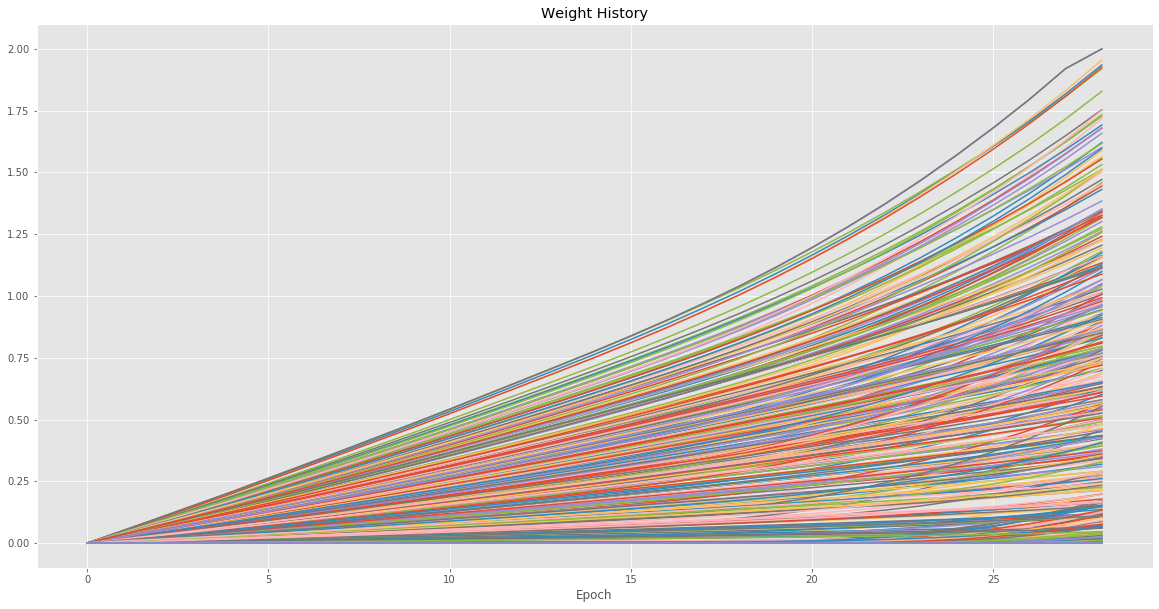

In [25]:
digits = load_digits()

u_t = 2000 # units of time
t_a = 1000 # training injection amount
s_a = -100 # training supression amount

input_limit = 100
pixels_per_digit = len(digits.data[0])
intensity_multiplier = 500
digit_types = 10 # max: 10, min: 1

# preprocess data
inputs = np.zeros((input_limit, pixels_per_digit, u_t), float)
trainings = np.zeros((input_limit, digit_types, u_t), float)

for i, (digit, target) in enumerate(zip(digits.data, digits.target[:input_limit])):
    digit_voltage_stream = np.zeros((pixels_per_digit, u_t), float)
    training_voltage_stream = np.zeros((digit_types, u_t), float)
    
    for j, pixel in enumerate(digit):
        digit_voltage_stream[j] = np.array([pixel * intensity_multiplier] * u_t)
         
    assert target < digit_types
    for j in range(digit_types):
        training_voltage_stream[j] = np.array([t_a] * u_t) if j == target else np.array([s_a] * u_t)
        
    inputs[i] = digit_voltage_stream
    trainings[i] = training_voltage_stream

weights = np.zeros((pixels_per_digit, digit_types))
    
# feed into network
digit_network = SingleLayerSNN(inputs=inputs[:input_limit], weights=weights, trainings=trainings)
digit_network.train(epochs=28, a_corr=0.0000000001, w_max=2.0, w_decay=0.0001, show_legend=False)


In [ ]:
# predict the first 10 images in the dataset
digit_network.predict(inputs[:10], bar_width=0.1);

In [ ]:
# predict second 10 images
digit_network.predict(inputs[10:20], bar_width=0.1);

In [ ]:
# predict 100th 10 images (new data)
digit_network.predict(inputs[20:30], bar_width=0.1);

In [ ]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
b = np.pad(b, (0, len(a) - len(b)), "constant")
c = [2, 3, 5]

shuffled, order = shuffle_forward(a)
print('shuffled:', shuffled)
unshuffled = shuffle_backward(shuffled, order)
print('unshuffled:', unshuffled)


In [ ]:
np.repeat([[1],[2],[3]], 4, axis=1)